## Introduction
This is a getting started tutorial for Gammapy.

In this tutorial we will manipulate objects representing maps in Gammapy. 

In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

## Maps
The maps package contains classes to work with sky images and cubes.

In this section, we will use a simple 2D sky image and will learn how to:
- Read sky images from FITS files
- Smooth images
- Plot images
- Cutout parts from images


In [3]:
from gammapy.maps import Map

gc_3fhl = Map.read("$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc-counts.fits.gz")

The image is a WcsNDMap object:

In [4]:
print(gc_3fhl)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat']
	shape : (400, 200)
	ndim  : 2
	unit  : 
	dtype : >i8



It contains a `WcsGeom` object and data stored as a `numpy.ndarray`.

In [5]:
print(gc_3fhl.data)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


The shape of the image is 400 x 200 pixel and it is defined using a cartesian projection in galactic coordinates.

In [6]:
print(gc_3fhl.geom)

WcsGeom

	axes       : ['lon', 'lat']
	shape      : (400, 200)
	ndim       : 2
	frame      : galactic
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 20.0 deg x 10.0 deg
	wcs ref    : 0.0 deg, 0.0 deg



In [7]:
# define the position of the Galactic center and anti-center
positions = SkyCoord([0, 180], [0, 0], frame="galactic", unit="deg")
gc_3fhl.geom.contains(positions)

array([ True, False])

Regular numpy operations can be performed on the `data` attribute.

In [8]:
total = gc_3fhl.data.sum()
print(f"Total number of counts in the image: {total:.0f}")

Total number of counts in the image: 32684


To show the image on the screen we can use the plot method. It basically calls plt.imshow, passing the gc_3fhl.data attribute but in addition handles axis with world coordinates using astropy.visualization.wcsaxes and defines some defaults for nicer plots (e.g. the colormap ‘afmhot’):

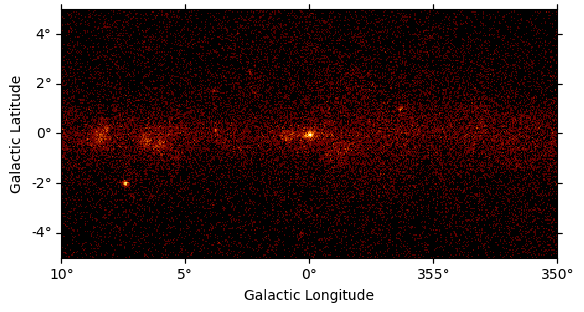

In [9]:
gc_3fhl.plot(stretch="sqrt")
plt.show()

To make the structures in the image more visible we will smooth the data using a Gaussian kernel.

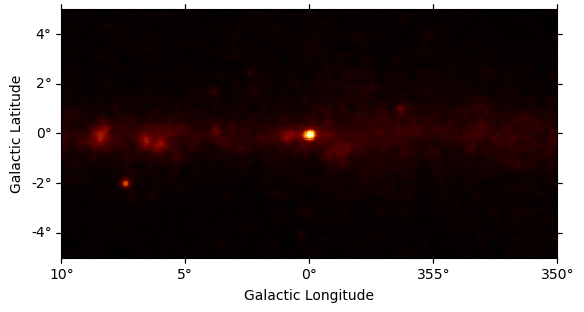

In [10]:
gc_3fhl_smoothed = gc_3fhl.smooth(kernel="gauss", width=0.1 * u.deg)
gc_3fhl_smoothed.plot(stretch="linear")
plt.show()

**Exercice** (see [Visualization in Maps API tutorial](https://docs.gammapy.org/1.2/tutorials/api/maps.html#visualizing-and-plotting)) : 
- Change the figure size
- Add a colorbar
- Change colormap (e.g. gray scale) 
- Try to change label font sizes 
- Try adding grids to the plot.

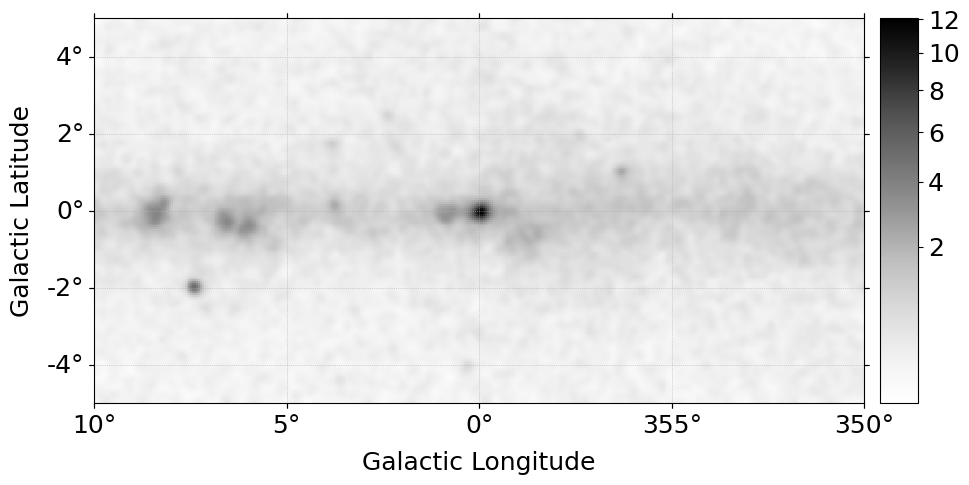

In [20]:
rc_params = {
    "figure.figsize": (12, 5),
    "font.size": 18,
}   
with plt.rc_context(rc=rc_params):
    ax = gc_3fhl_smoothed.plot(stretch="sqrt", add_cbar=True, cmap='Greys')
    ax.grid(linestyle='dotted', linewidth=0.5)

The smoothed plot already looks much nicer, but still the image is rather large. As we are mostly interested in the inner part of the image, we will cut out a quadratic region of the size 9 deg x 9 deg around the GC. Therefore we use cutout to make a cutout map:

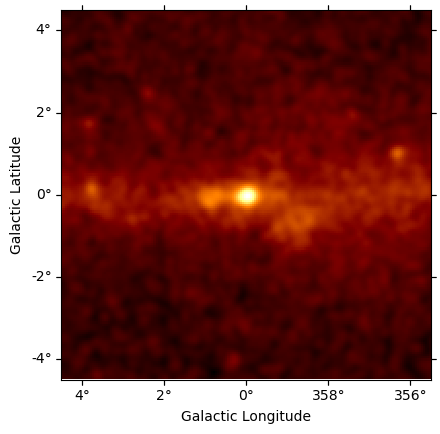

In [12]:
# define center and size of the cutout region
center = SkyCoord(0, 0, unit="deg", frame="galactic")
gc_3fhl_cutout = gc_3fhl_smoothed.cutout(center, 9 * u.deg)
gc_3fhl_cutout.plot(stretch="sqrt")
plt.show()

### With non-spatial axis



In [13]:
fermi_gc = Map.read("$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc-counts-cube.fits.gz")
print(fermi_gc)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (400, 200, 11)
	ndim  : 3
	unit  : 
	dtype : >i4



In [14]:
fermi_gc.smooth(kernel="gauss", width=0.3*u.deg).plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

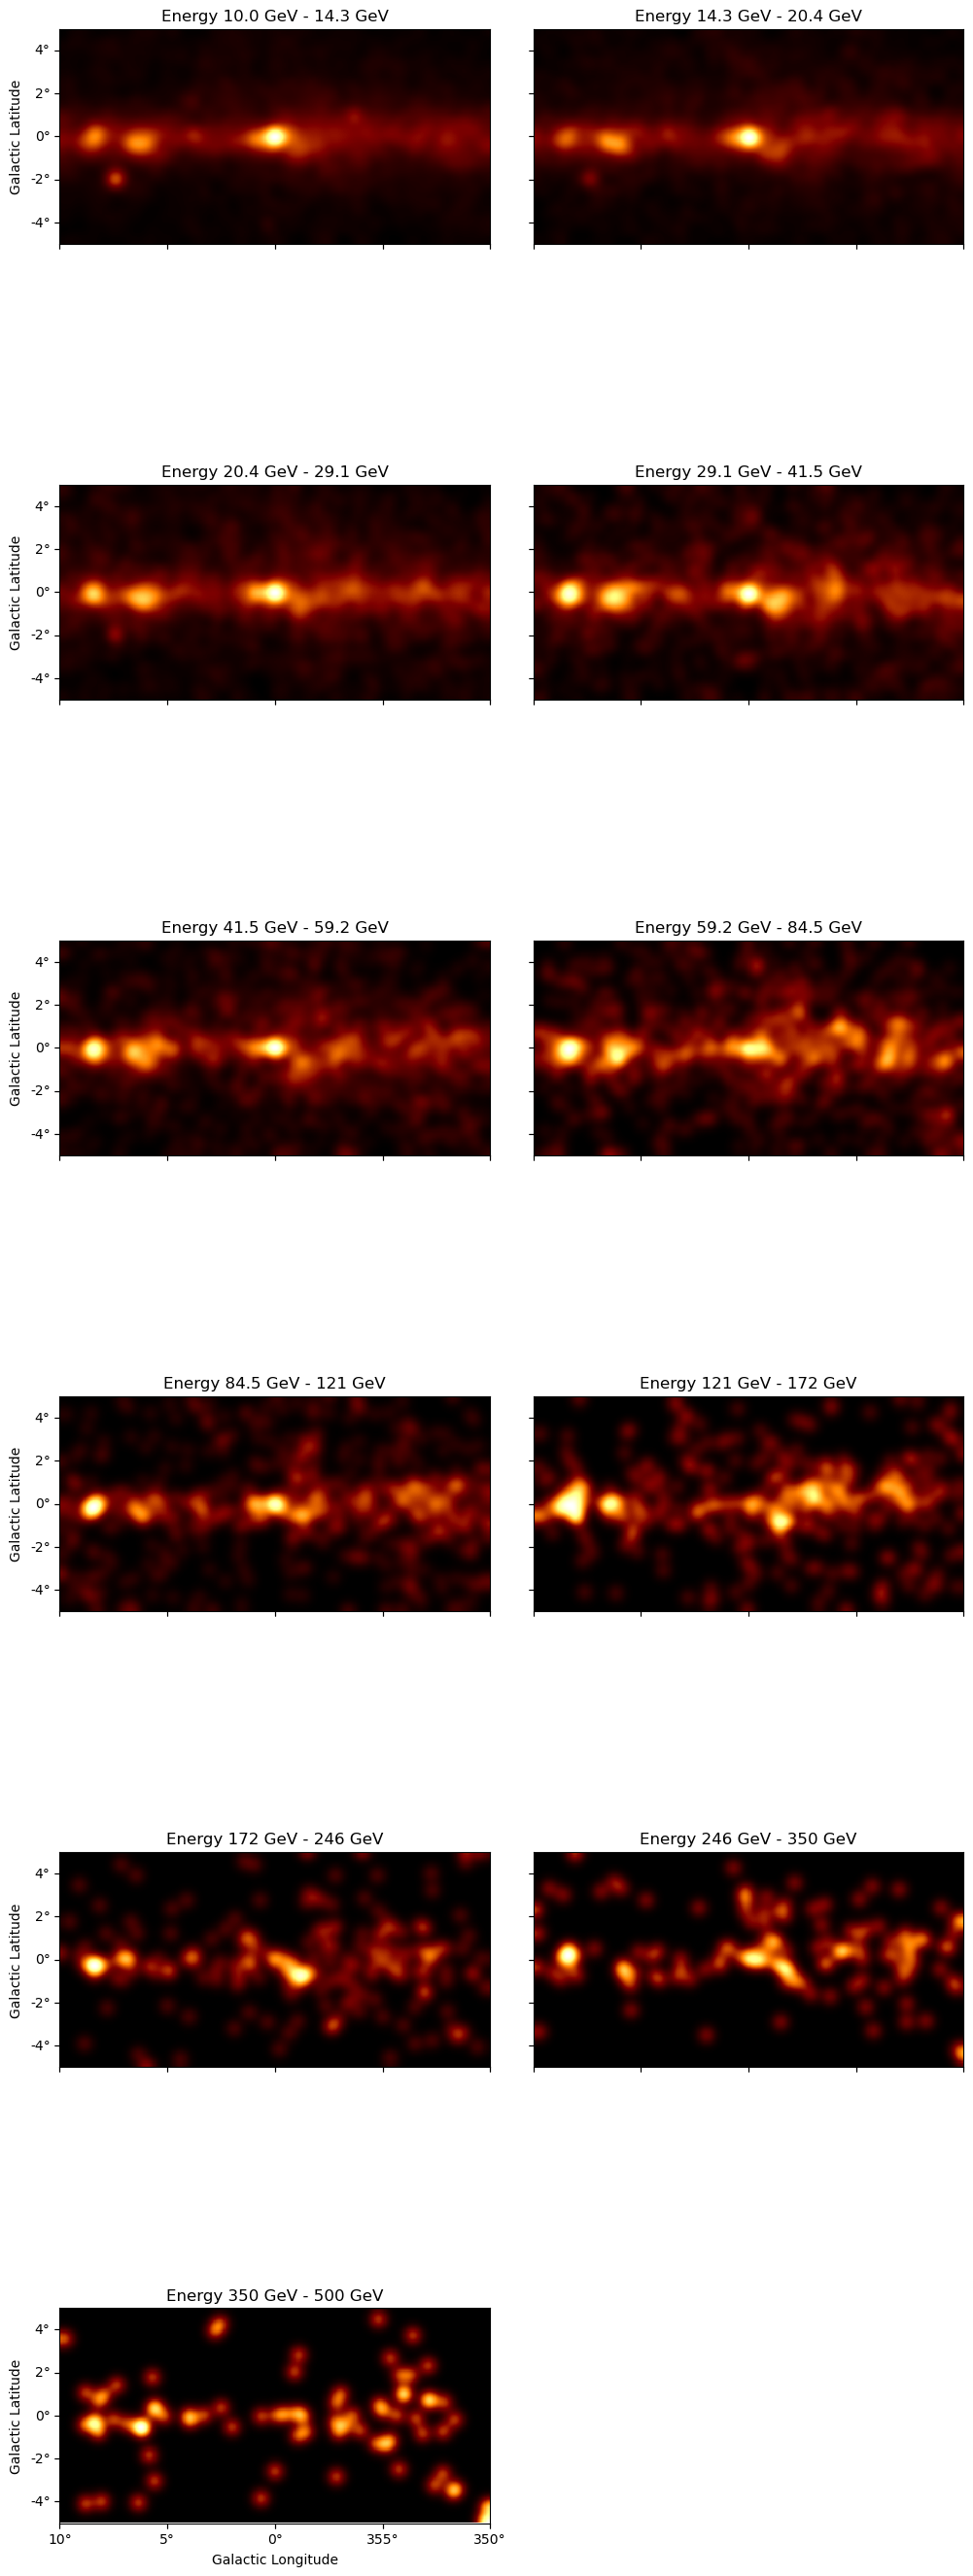

In [14]:
axes = fermi_gc.smooth(kernel="gauss", width=0.3*u.deg).plot_grid(ncols=2)

### Creating from a Map Geometry
The Map object couples the data (stored as a ndarray) with a Geom object. The ~Geom object can be seen as a generalization of an astropy.wcs.WCS object, providing the information on how the data maps to physical coordinate systems. In some cases e.g. when creating many maps with the same WCS geometry it can be advantageous to first create the map geometry independent of the map object it-self:

In [15]:
from gammapy.maps import WcsGeom
wcs_geom = WcsGeom.create(binsz=0.02, width=(10, 5), skydir=(0, 0), frame="galactic", proj="CAR")

In [16]:
print(wcs_geom.center_skydir)

<SkyCoord (Galactic): (l, b) in deg
    (0., 0.)>


**Exercice** : Create and plot an ampty all sky map in Hammer Aitoff projection with 0.5° bin size.

<WCSAxes: >

/Users/terrier/Code/mambaforge/envs/gammapy-1.2/lib/python3.10/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/terrier/Code/mambaforge/envs/gammapy-1.2/lib/python3.10/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/terrier/Code/mambaforge/envs/gammapy-1.2/lib/python3.10/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


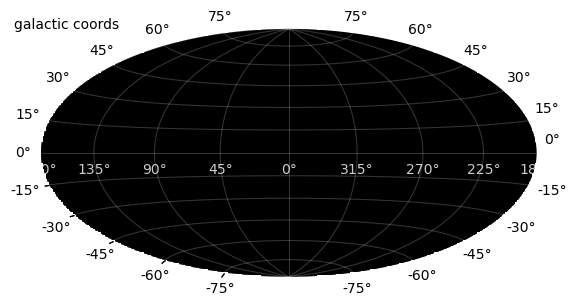

In [17]:
full_sky_geom = WcsGeom.create(binsz=1, skydir=(0, 0), frame="galactic", proj="AIT")
Map.from_geom(full_sky_geom).plot()

### Adding Non-Spatial Axes
In many analysis scenarios we would like to add extra dimension to the maps to study e.g. energy or time dependency of the data. Those non-spatial dimensions are handled with the MapAxis object. Let us first define an energy axis, with 4 bins:

In [18]:
from gammapy.maps import MapAxis
energy_axis = MapAxis.from_energy_bounds(0.1, 100, nbin=12, unit="TeV", name="energy")
print(energy_axis)

MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 12        
	node type  : edges     
	edges min  : 1.0e-01 TeV
	edges max  : 1.0e+02 TeV
	interp     : log       



**Exercice:** create an **energy true** axis with around 6 bins per decade between 40 GeV and 200 TeV.

*Hint : check MapAxis.from_energy_bounds docstring.*

In [19]:
# true energy refers to true photon energy opposed to measured energy. In gammapy, we represent it with axes names "energy_true"
energy_true_axis = MapAxis.from_energy_bounds(0.04, 200, nbin=6, unit="TeV", name="energy_true", per_decade=True)
print(energy_true_axis)

MapAxis

	name       : energy_true
	unit       : 'TeV'     
	nbins      : 23        
	node type  : edges     
	edges min  : 4.0e-02 TeV
	edges max  : 2.0e+02 TeV
	interp     : log       



In [20]:
#check edges
print(energy_axis.edges)

[1.00000000e-01 1.77827941e-01 3.16227766e-01 5.62341325e-01
 1.00000000e+00 1.77827941e+00 3.16227766e+00 5.62341325e+00
 1.00000000e+01 1.77827941e+01 3.16227766e+01 5.62341325e+01
 1.00000000e+02] TeV


In [21]:
wcs_geom_3d = WcsGeom.create(binsz=0.02, width=(10, 5), skydir=(0, 0), frame="galactic", proj="CAR", axes=[energy_axis])

In [22]:
print(wcs_geom_3d)

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (500, 250, 12)
	ndim       : 3
	frame      : galactic
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 deg x 5.0 deg
	wcs ref    : 0.0 deg, 0.0 deg



### Units, arithmetics

In [23]:
area = Map.from_geom(wcs_geom_3d, data=1, unit="m2")

In [24]:
area.quantity.to("cm2")

<Quantity [[[10000., 10000., 10000., ..., 10000., 10000., 10000.],
            [10000., 10000., 10000., ..., 10000., 10000., 10000.],
            [10000., 10000., 10000., ..., 10000., 10000., 10000.],
            ...,
            [10000., 10000., 10000., ..., 10000., 10000., 10000.],
            [10000., 10000., 10000., ..., 10000., 10000., 10000.],
            [10000., 10000., 10000., ..., 10000., 10000., 10000.]],

           [[10000., 10000., 10000., ..., 10000., 10000., 10000.],
            [10000., 10000., 10000., ..., 10000., 10000., 10000.],
            [10000., 10000., 10000., ..., 10000., 10000., 10000.],
            ...,
            [10000., 10000., 10000., ..., 10000., 10000., 10000.],
            [10000., 10000., 10000., ..., 10000., 10000., 10000.],
            [10000., 10000., 10000., ..., 10000., 10000., 10000.]],

           [[10000., 10000., 10000., ..., 10000., 10000., 10000.],
            [10000., 10000., 10000., ..., 10000., 10000., 10000.],
            [10000., 100

In [25]:
time = Map.from_geom(wcs_geom_3d, data=1, unit="h")

In [26]:
exposure = time * area

In [27]:
print(exposure)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (500, 250, 12)
	ndim  : 3
	unit  : m2 h
	dtype : float64



In [28]:
exposure.quantity.to("cm2s")

<Quantity [[[36000000., 36000000., 36000000., ..., 36000000., 36000000.,
             36000000.],
            [36000000., 36000000., 36000000., ..., 36000000., 36000000.,
             36000000.],
            [36000000., 36000000., 36000000., ..., 36000000., 36000000.,
             36000000.],
            ...,
            [36000000., 36000000., 36000000., ..., 36000000., 36000000.,
             36000000.],
            [36000000., 36000000., 36000000., ..., 36000000., 36000000.,
             36000000.],
            [36000000., 36000000., 36000000., ..., 36000000., 36000000.,
             36000000.]],

           [[36000000., 36000000., 36000000., ..., 36000000., 36000000.,
             36000000.],
            [36000000., 36000000., 36000000., ..., 36000000., 36000000.,
             36000000.],
            [36000000., 36000000., 36000000., ..., 36000000., 36000000.,
             36000000.],
            ...,
            [36000000., 36000000., 36000000., ..., 36000000., 36000000.,
         

**Exercice**: build a simple integrated *intensity* map of the 3FHL GC dataset from Fermi-LAT. You can use
- the integrated exposure map at $GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc-exposure.fits.gz
- a smoothed version of the integrated counts map above

*Hint: the unit is not defined in the exposure map header. It is in $cm^2\ s$.*
*Note that `smooth` perform a normalized convolution. The resulting intesinty map is therefore flux per pixel. The peak of the emission does not give the source flux.*

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat']
	shape : (400, 200)
	ndim  : 2
	unit  : 
	dtype : >f4



<WCSAxes: >

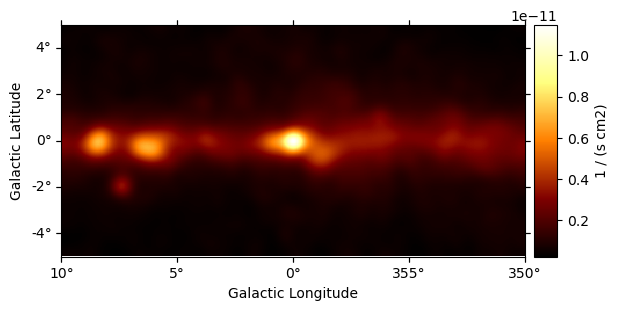

In [29]:
gc_3fhl_expo = Map.read("$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc-exposure.fits.gz")
print(gc_3fhl_expo)

# This does not work
# gc_3fhl_expo.unit = "cm2 s"

# instead we copy the map and change the unit attribute
gc_3fhl_expo = gc_3fhl_expo.copy(unit="cm2 s")

# we apply the arithmetics
gc_3fhl_flux = gc_3fhl.smooth(width=0.3*u.deg)/gc_3fhl_expo.smooth(width=0.3*u.deg)
gc_3fhl_flux.plot(add_cbar=True)

### RegionGeom : geometries with one spatial bin

In [30]:
from regions import CircleSkyRegion

GC_position = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")
region = CircleSkyRegion(GC_position, radius=0.3*u.deg)

In [31]:
from gammapy.maps import RegionGeom

In [32]:
geom = RegionGeom.create(region, axes=[energy_axis])
map1D = Map.from_geom(geom)
print(map1D)

RegionNDMap

	geom  : RegionGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (1, 1, 12)
	ndim  : 3
	unit  : 
	dtype : float32



You can then extract informations on the `RegionGeom` as for any other `Geom`.

In [33]:
print(geom.region)
print(f"The solid angle is {geom.solid_angle()}")

Region: CircleSkyRegion
center: <SkyCoord (Galactic): (l, b) in deg
    (359.94, -0.04)>
radius: 0.3 deg
The solid angle is 8.612854634074744e-05 sr


Does the geom contain a specific position?

In [34]:
other_position = SkyCoord(0.5,0, unit="deg", frame="galactic")
geom.contains(other_position)

array([False])

### Extracting a RegionNDMap (1D spectrum) from a WCSNDMap (3D cube)

You can extract the information from the 3D map and combine it into a 1D map

In [35]:
gc_3fhl.to_region_nd_map(region)

In [36]:
fermi_gc_region = fermi_gc.to_region_nd_map(region=region)
print(fermi_gc_region)

RegionNDMap

	geom  : RegionGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (1, 1, 11)
	ndim  : 3
	unit  : 
	dtype : int64



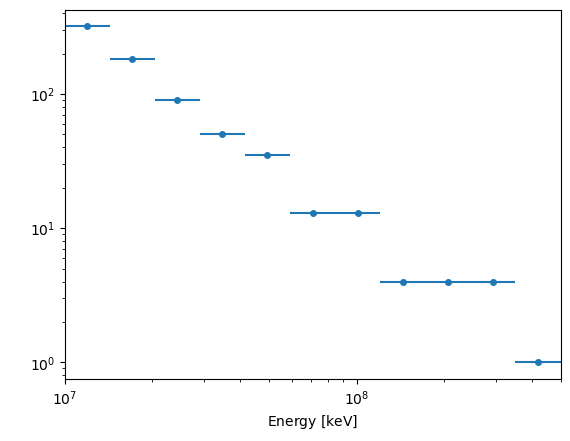

In [37]:
ax = fermi_gc_region.plot()

**Exercice**: build a region map containing the counts integrated between (-0.5° < GLAT < 0.5°)